In [53]:
# setup
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

In [54]:
train_df_ori = pd.read_csv('titanic_data/train.csv')
test_df_ori = pd.read_csv('titanic_data/test.csv')

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()

In [55]:
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
irrelevant_feats = ['PassengerId', 'Name']
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

In [57]:
missing_too_many = ['Cabin', 'Ticket']
train_df.drop(missing_too_many, axis=1, inplace=True)
test_df.drop(missing_too_many, axis=1, inplace=True)

In [58]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
age_fill = imputer.fit_transform(train_df['Age'].values.reshape(-1,1))
train_df['Age'] = age_fill
age_fill = imputer.transform(test_df['Age'].values.reshape(-1,1))
test_df['Age'] = age_fill

In [59]:
display(train_df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [60]:
def dataframe_onehotencoder(encoder, df, columns_names, fit_transform=True):
    '''
    This is a helper function to apply sklearn onehotencoder function
    on multiple columns of a data frame.

    Args:
        encoder: initialized OneHotEncoder
        df: Pandas dataframe with data
        columns_names: names of the columns in dataframe to encode
        fit_transform: True when the encoder is seeing the categorical data for the first time; False otherwise.
    
    Returns:
        dataframe: with one-hot-encoded columns
    '''
    
    # One-hot-encode the columns in column names
    if(fit_transform):
        data = encoder.fit_transform(df[columns_names])
    else:
        data = encoder.transform(df[columns_names])

    # Convert data to a dataframe
    df2 = pd.DataFrame(data, columns=encoder.get_feature_names_out(columns_names), index=df.index)
    
    # Recreate original dataframe
    df3 = pd.concat([df.drop(columns_names, axis=1), df2], axis=1)
    
    # Return
    return df3 

In [61]:
columns_to_encode = ['Sex', 'Embarked']
encoder = OneHotEncoder(drop='first', sparse=False) # drops first feature to avoid colinear features
df_OHE = dataframe_onehotencoder(encoder=encoder, df=train_df, columns_names=columns_to_encode, fit_transform=True)
display(df_OHE.head())

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Embarked_nan
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0,0.0


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Embarked_nan
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0,0.0


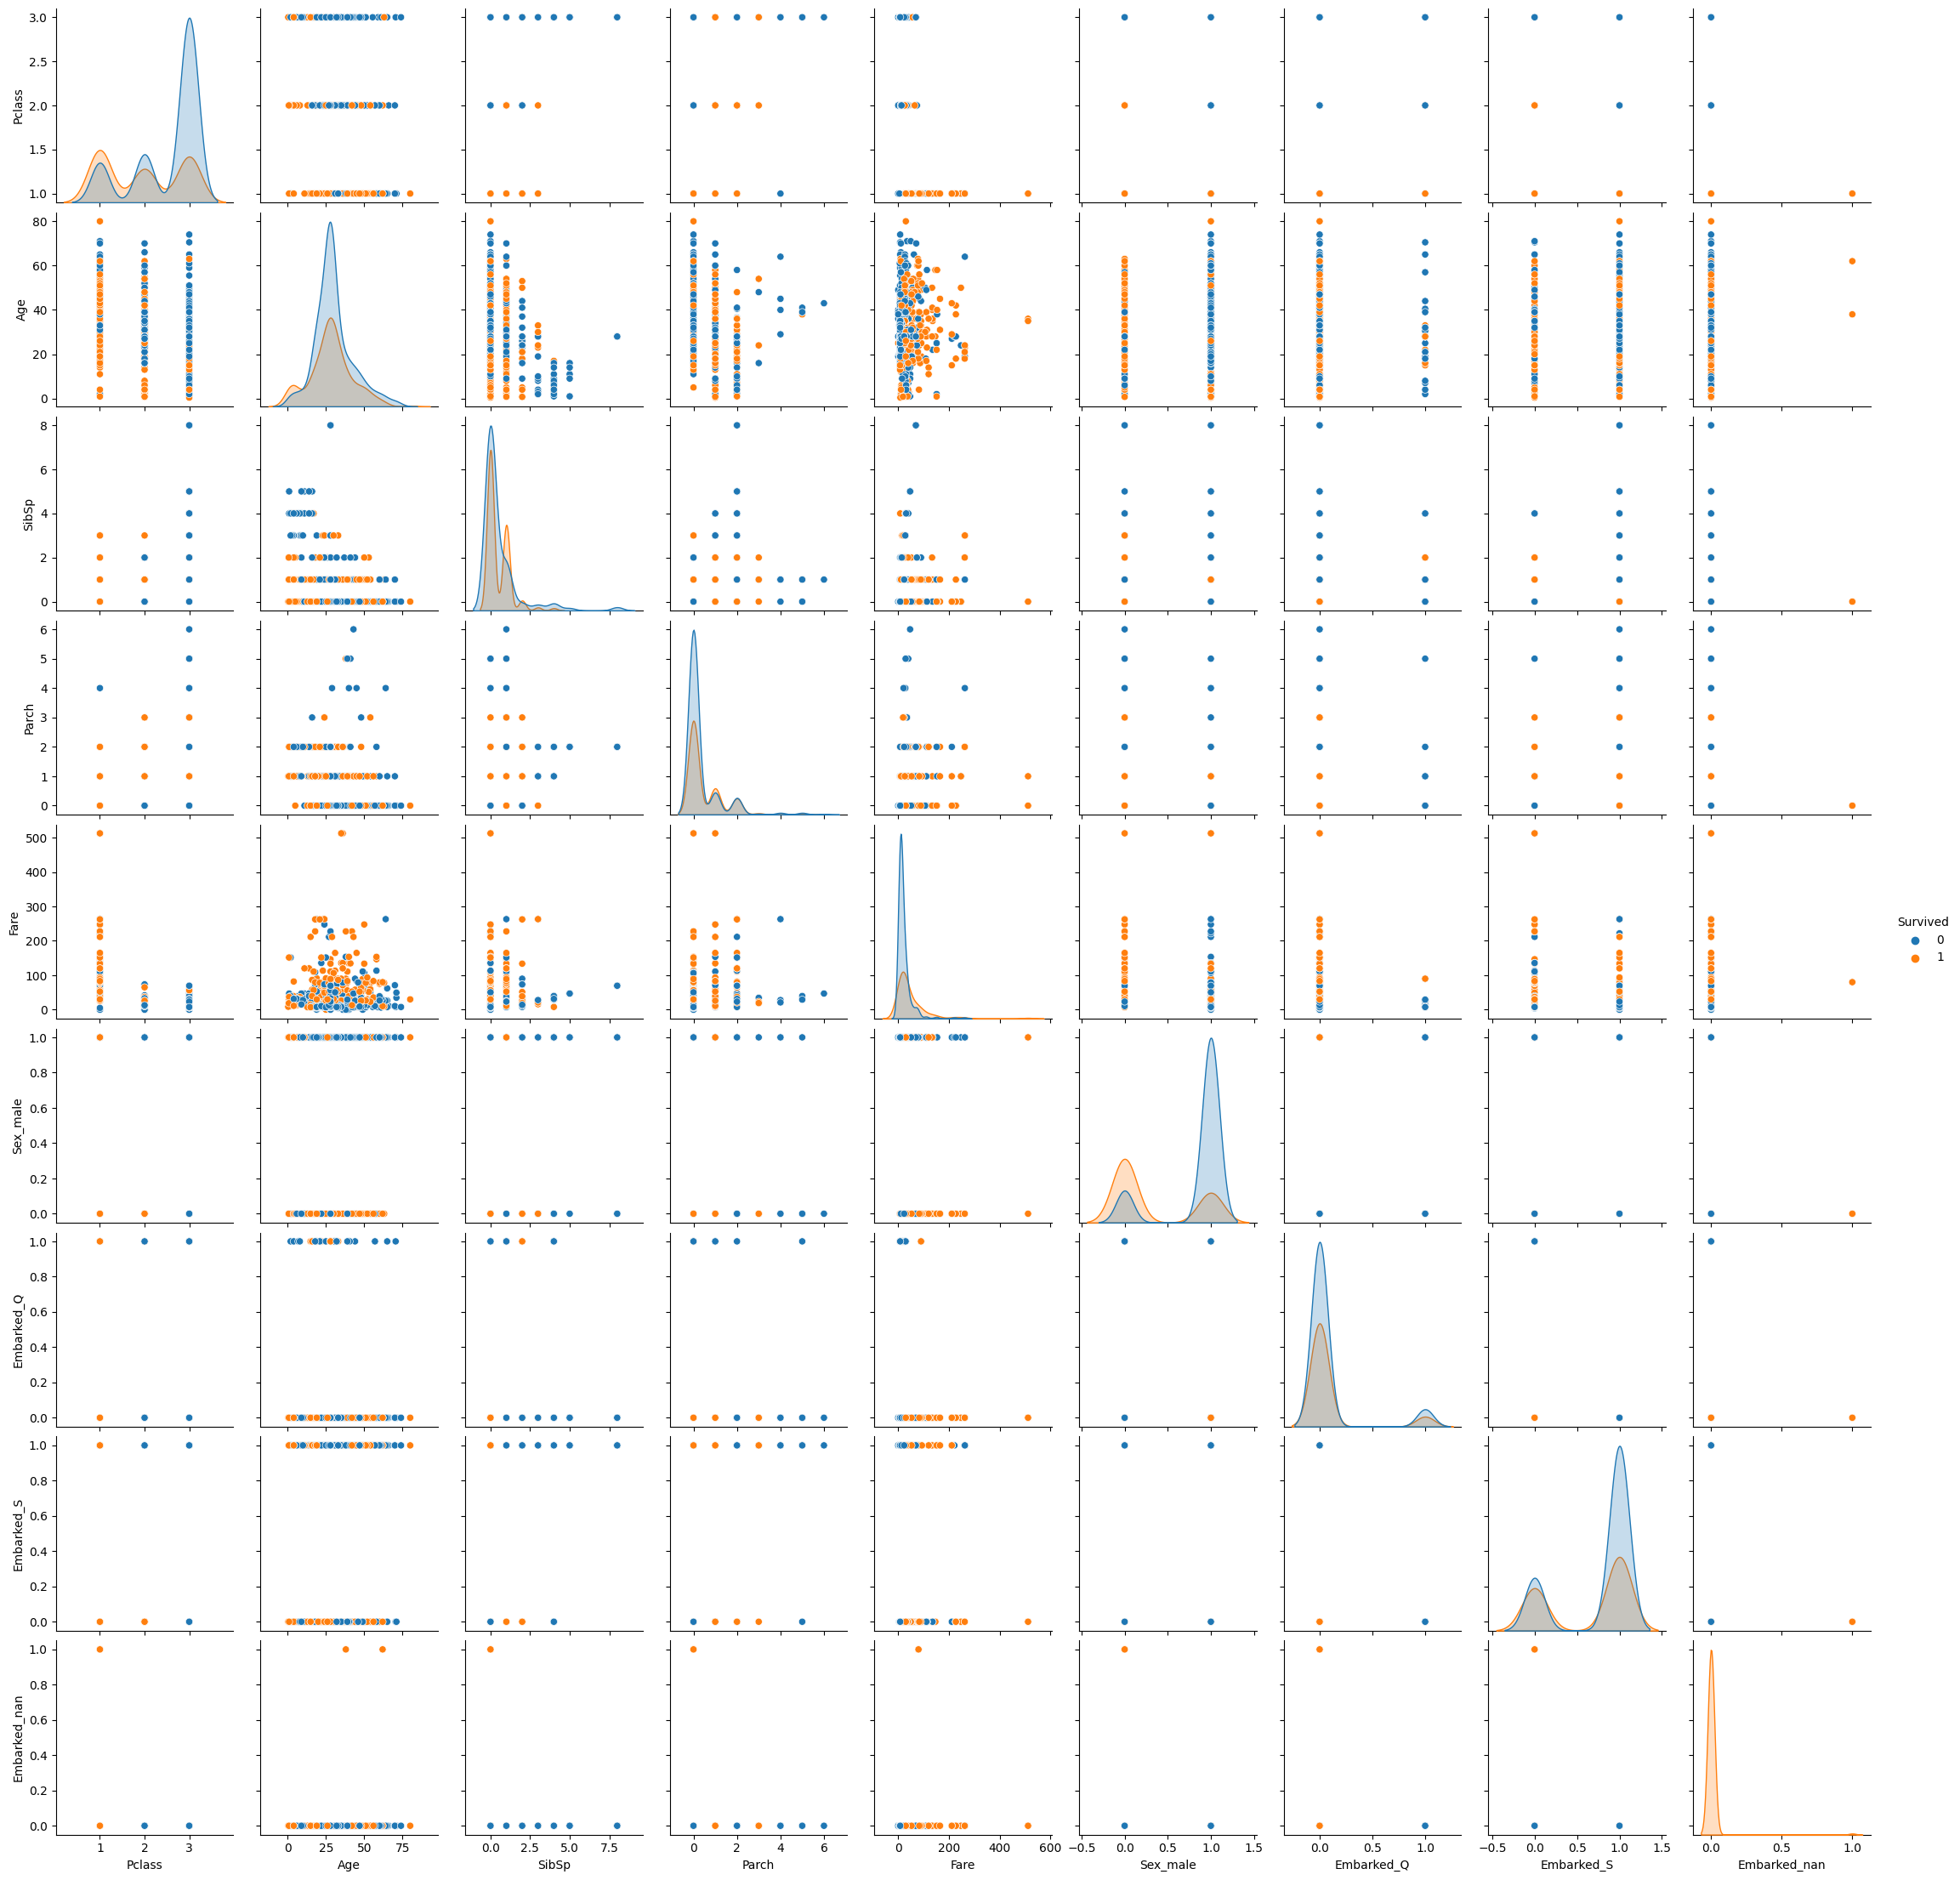

In [62]:
# Display current dataframe
display(df_OHE.head())

# Display scatter plots
sns.pairplot(df_OHE, hue='Survived')

In [63]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Embarked_nan
0,0,1.0,-0.565736,0.432793,0.000000,-0.502445,1.0,0.0,1.0,0.0
1,1,0.0,0.663861,0.432793,0.000000,0.786845,0.0,0.0,0.0,0.0
2,1,1.0,-0.258337,-0.474545,0.000000,-0.488854,0.0,0.0,1.0,0.0
3,1,0.0,0.433312,0.432793,0.000000,0.420730,0.0,0.0,1.0,0.0
4,0,1.0,0.433312,-0.474545,0.000000,-0.486337,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0,0.5,-0.181487,-0.474545,0.000000,-0.386671,1.0,0.0,1.0,0.0
887,1,0.0,-0.796286,-0.474545,0.000000,-0.044381,0.0,0.0,1.0,0.0
888,0,1.0,-0.104637,0.432793,0.333333,-0.176263,0.0,0.0,1.0,0.0
889,1,0.0,-0.258337,-0.474545,0.000000,-0.044381,1.0,0.0,0.0,0.0


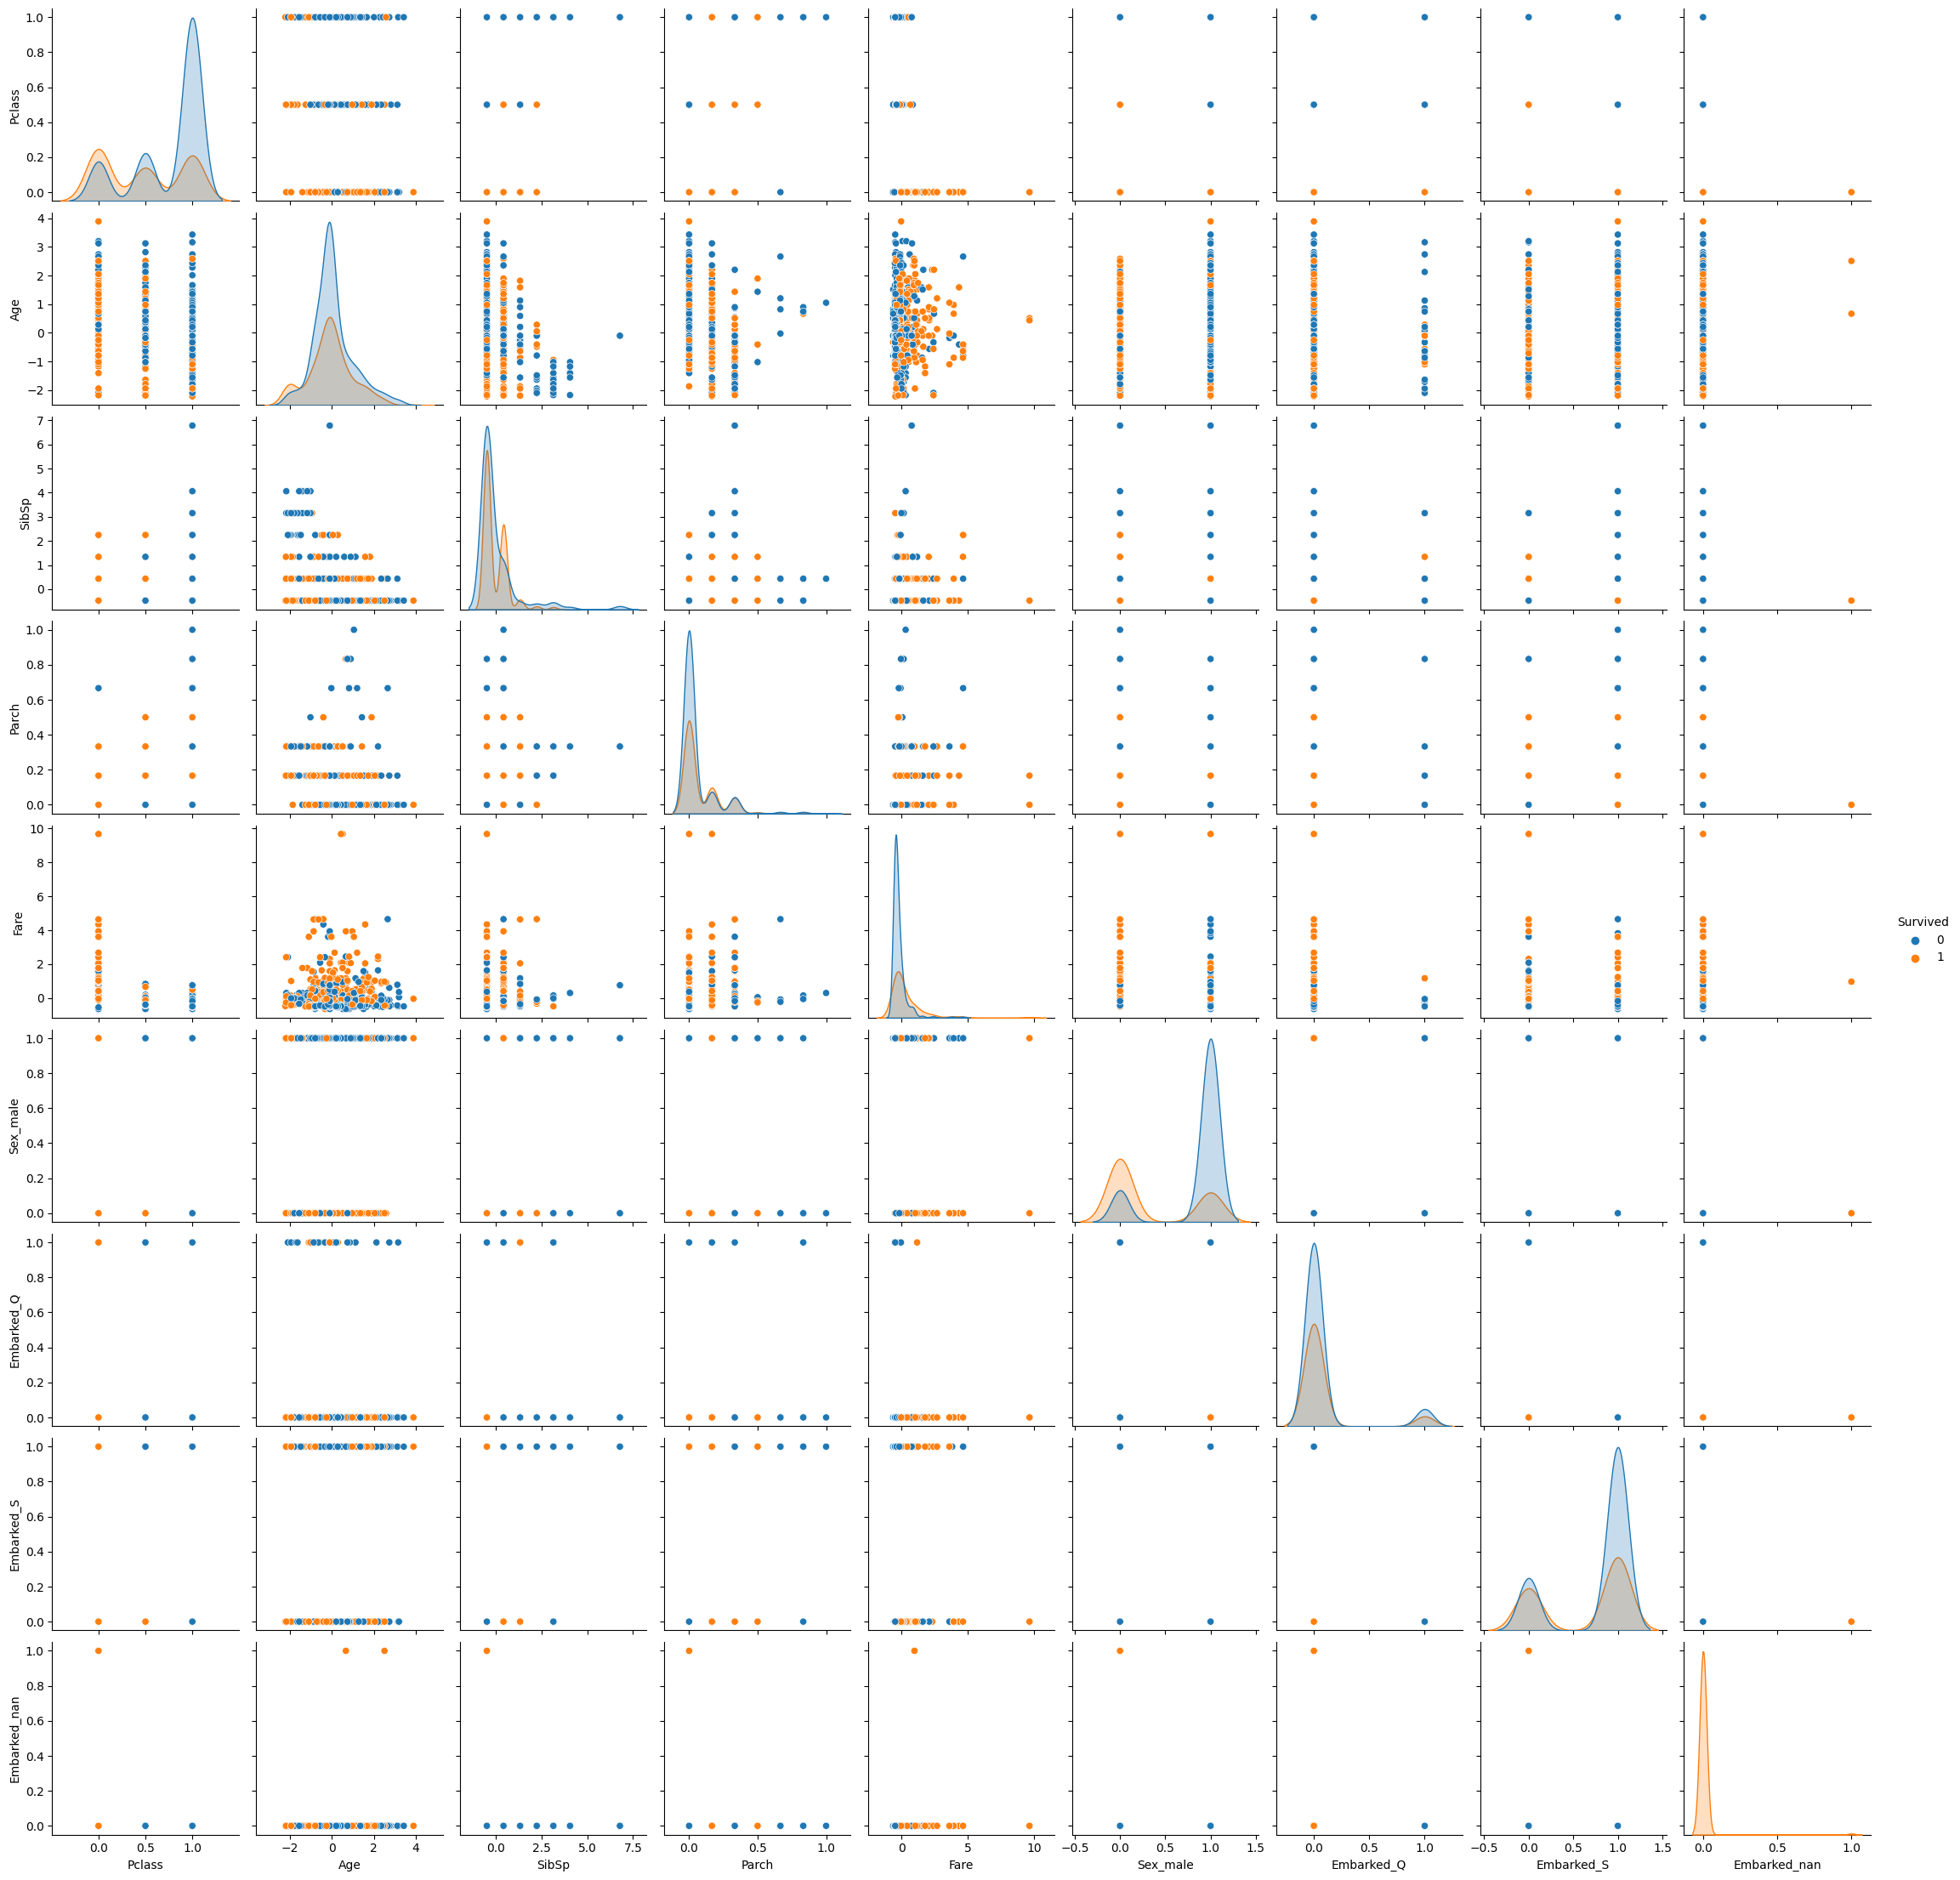

In [64]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=df_OHE, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=df_OHE, fit_transform=False)

# Display table
display(train_df2)

# Display seaborn pairplot
sns.pairplot(train_df2, hue='Survived')

# Note we are storing normalization in a new dataframe for display purposes. There 
# is a more elegant framework using pipelines, but it requires to move to Numpy.

In [76]:
y = train_df2['Survived'].values
X = train_df2.iloc[:,1:].values

In [77]:
y_test = test_df2['Survived'].values
X_test = test_df2.iloc[:,1:].values

In [79]:
clf = LogisticRegression(max_iter = 1000, random_state = rng1).fit(X, y)

In [80]:
clf.predict(X_test)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,

In [81]:
clf.predict_proba(X_test)

array([[0.90666582, 0.09333418],
       [0.09038123, 0.90961877],
       [0.3793064 , 0.6206936 ],
       ...,
       [0.49412225, 0.50587775],
       [0.40726615, 0.59273385],
       [0.87871335, 0.12128665]])

In [82]:
clf.score(X_test, y_test)

0.8002244668911336